# Setup

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

%load_ext autoreload
%autoreload 2
import pandas as pd
import networkx as nx
import numpy as np
from disambiguation import Disambiguator, Disambiguator1880
import disambiguation.analysis as da
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
pd.set_option('display.min_rows', 1000)
pd.set_option('display.max_columns', 55)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [18]:
match = pd.read_csv("../data/matches.csv")

In [19]:
census_latlng = pd.read_csv("../data/census_1880_mn_v04.csv")

In [20]:
census_latlng['CENSUS_ID'] = 'CENSUS_' + census_latlng['OBJECTID.x'].astype(str)
census_latlng = census_latlng.loc[:, ['CENSUS_ID', 'CENSUS_X', 'CENSUS_Y']]

In [21]:
# fix an outlier
census_latlng.loc[census_latlng.CENSUS_Y > 1000, 'CENSUS_Y'] = 40.799935

## Set 1: Density Clustering +  K-Between

In [8]:
basic = Disambiguator1880(match)
basic.run_disambiguation()

Running
Creating dictionary of sub dfs (1/4)...
Applying algorithms iteratively (2/4)...
Cleaning output (3/4)...
Disambiguating (4/4)...
Done! :)


In [9]:
basic.save_result("../data/disambiguated_cluster_kbtw.csv")

In [10]:
basic.merge_census_var(census_latlng)
basic.set_var()

In [11]:
basic_match_rate = basic.get_match_rate()
basic_addr_success = basic.get_addr_success()
basic_dist_error = basic.get_dist_error()
basic_under12 = basic.get_under12_selections()

In [31]:
pickle.dump(basic, open('../data/disambiguated_cluster_kbtw.pkl', 'wb'))

## Set 2: Density Clustering + Shortest Path

In [12]:
dijk = Disambiguator1880(match)
dijk.run_disambiguation(k_between=False)

Running
Creating dictionary of sub dfs (1/4)...
Applying algorithms iteratively (2/4)...
Cleaning output (3/4)...
Disambiguating (4/4)...
Done! :)


In [13]:
dijk.save_result("../data/disambiguated_cluster_dijk.csv")

In [14]:
dijk.merge_census_var(census_latlng)
dijk.set_var()

In [16]:
dijk_match_rate = dijk.get_match_rate()
dijk_addr_success = dijk.get_addr_success()
dijk_dist_error = dijk.get_dist_error()
dijk_under12 = dijk.get_under12_selections()

In [32]:
pickle.dump(dijk, open('../data/disambiguated_cluster_dijk.pkl', 'wb'))

## Set 3: No Clustering + K-Between

In [20]:
no_clus = Disambiguator1880(match)
no_clus.run_disambiguation(cluster=False)

Running
Creating dictionary of sub dfs (1/4)...
Applying algorithms iteratively (2/4)...
Cleaning output (3/4)...
Disambiguating (4/4)...
Done! :)


In [21]:
no_clus.save_result("../data/disambiguated_noclus.csv")

In [22]:
no_clus.merge_census_var(census_latlng)
no_clus.set_var()

In [24]:
no_clus_match_rate = no_clus.get_match_rate()
no_clus_addr_success = no_clus.get_addr_success()
no_clus_dist_error = no_clus.get_dist_error()
no_clus_under12 = no_clus.get_under12_selections()

In [33]:
pickle.dump(no_clus, open('../data/disambiguated_noclus.pkl', 'wb'))

## Set 4: No Clustering + Shortest Path

In [25]:
no_all = Disambiguator1880(match)
no_all.run_disambiguation(cluster=False, k_between=False)

Running
Creating dictionary of sub dfs (1/4)...
Applying algorithms iteratively (2/4)...
Cleaning output (3/4)...
Disambiguating (4/4)...
Done! :)


In [26]:
no_all.save_result("../data/disambiguated_noall.csv")

In [27]:
no_all.merge_census_var(census_latlng)
no_all.set_var()

In [28]:
no_all_match_rate = no_all.get_match_rate()
no_all_addr_success = no_all.get_addr_success()
no_all_dist_error = no_all.get_dist_error()
no_all_under12 = no_all.get_under12_selections()

In [34]:
pickle.dump(no_all, open("../data/disambiguated_noall.pkl", "wb"))

## Benchmarking

In [22]:
match = match.merge(census_latlng, how="inner", on='CENSUS_ID', validate='many_to_one')

In [23]:
df_dist = da.get_dist_based_match(match)

In [24]:
df_dist = df_dist['results']

In [38]:
df_dist.columns

Index(['Unnamed: 0', 'CD_ID', 'CD_FIRST_NAME', 'CD_LAST_NAME', 'MATCH_ADDR',
       'CD_OCCUPATION', 'num_matches', 'CENSUS_ID', 'CENSUS_NAMEFRSCLEAN',
       'CENSUS_NAMELASTB', 'CENSUS_MATCH_ADDR', 'CENSUS_AGE',
       'CENSUS_OCCLABELB', 'WARD_NUM', 'CENSUS_ENUMDIST', 'CENSUS_SEGMENT_ID',
       'CD_BLOCK_NUM', 'census_occupation_listed', 'jaro_winkler_aggr_score',
       'confidence_score', 'LONG', 'LAT', 'age_score', 'census_count',
       'anchor', 'CENSUS_X', 'CENSUS_Y', 'dist', 'dist_weight', 'selected',
       'graph_ID'],
      dtype='object')

In [40]:
base_match_rate = da.get_match_rate(df_dist)
base_addr_success = da.get_addr_success(df_dist)
base_dist_error = da.get_dist_error(df_dist)
base_under12 = da.get_under12_selections(df_dist)

## Exploration of Results

In [103]:
labs = ('True\n Match Rate', 'Clustering \nK-Between', 'Clustering \nShortest Path', 'No Clustering\nK-Between', 'No Clustering\nShortest Path')
pos = np.arange(len(match_rates_labs)) * 5
pal = ['#de6600', '#fea02f', '#ebd9c8', '#007a7a', '#003f5a']

### Match Rate
How many matches are successfully retrieved?

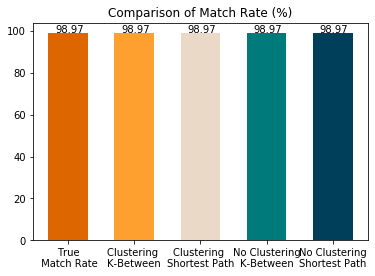

In [104]:
# barplot of match rate
match_rates = [base_match_rate, basic_match_rate, dijk_match_rate, no_clus_match_rate, no_all_match_rate]

plt.bar(pos, match_rates, width=3, color=pal)
plt.xticks(pos, labs)
plt.title("Comparison of Match Rate (%)")
for i in range(0, len(pos)):
    plt.text(x=pos[i] - 1, y=match_rates[i] + 0.1, s = match_rates[i])
plt.show()

### Perfect Match Selection Rate
Of the number of perfect matches (in terms of address*), how many were selected?
* Some standardization was done

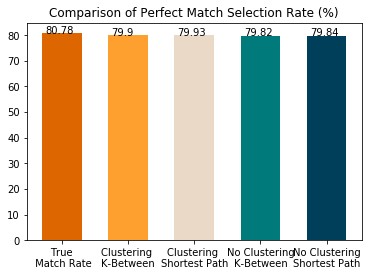

In [105]:
# barplot of match addr
n_perf_match = base_addr_success['n_perfect_match']
addr_successes = [base_addr_success['n_perfect_match_chosen'], basic_addr_success['n_perfect_match_chosen'], dijk_addr_success['n_perfect_match_chosen'], no_clus_addr_success['n_perfect_match_chosen'], no_all_addr_success['n_perfect_match_chosen']]
addr_successes = [round(rate / n_perf_match * 100, 2) for rate in addr_successes]

plt.bar(pos, addr_successes, width=3, color=pal)
plt.xticks(pos, labs)
plt.title("Comparison of Perfect Match Selection Rate (%)")
for i in range(0, len(pos)):
    plt.text(x=pos[i] - 1.25, y=addr_successes[i] + 0.01, s = addr_successes[i])
plt.show()

### Distance Between Census and Matched CD Record
An error measure 

In [77]:
# histogram of distance
base_dist = base_dist_error.loc[base_dist_error.selected == 1, :].dist
basic_dist = basic_dist_error.loc[basic_dist_error.selected == 1, :].dist
dijk_dist = dijk_dist_error.loc[dijk_dist_error.selected == 1, :].dist
noclus_dist = no_clus_dist_error.loc[no_clus_dist_error.selected == 1, :].dist
noall_dist = no_all_dist_error.loc[no_all_dist_error.selected == 1, :].dist

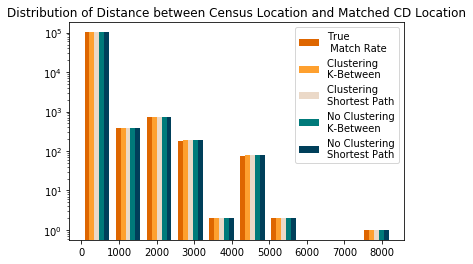

In [91]:
plt.hist([base_dist, basic_dist, dijk_dist, noclus_dist, noall_dist], log=True, label = labs, color=['#de6600', '#fea02f', '#ebd9c8', '#007a7a', '#003f5a'])
plt.legend()
plt.title('Distribution of Distance between Census Location and Matched CD Location')
plt.show()

In [93]:
# boxplots
base_dist_error["type"] = "True Match Rate"
base_bxplt = base_dist_error.loc[base_dist_error.selected == 1, ["dist", "type"]]
basic_dist_error["type"] = "Clustering\nK-Between"
basic_bxplt = basic_dist_error.loc[basic_dist_error.selected == 1, ["dist", "type"]]
dijk_dist_error["type"] = "Clusteirng\nShortest Path"
dijk_bxplt = dijk_dist_error.loc[dijk_dist_error.selected == 1, ["dist", "type"]]
no_clus_dist_error["type"] = "No Clustering\nK-Between"
noclus_bxplt = no_clus_dist_error.loc[no_clus_dist_error.selected == 1, ["dist", "type"]]
no_all_dist_error["type"] = "No Clustering\nShortest Path"
noall_bxplt = no_all_dist_error.loc[no_all_dist_error.selected == 1, ["dist", "type"]]

boxplot_dist = pd.concat([base_bxplt, basic_bxplt, dijk_bxplt, noclus_bxplt, noall_bxplt], ignore_index=True)

In [97]:
boxplot_dist['logged_dist'] = np.log(boxplot_dist['dist'])

Text(0.5, 1.0, 'Distribution of Distance between Census Location and Matched CD Location')

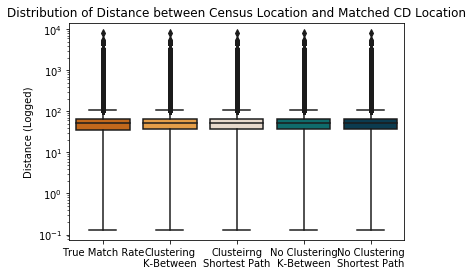

In [102]:
pal = {'True Match Rate': '#de6600', 'Clustering\nK-Between': '#fea02f', 'Clusteirng\nShortest Path': '#ebd9c8', 'No Clustering\nK-Between': '#007a7a', 'No Clustering\nShortest Path': '#003f5a'}
bp = sns.boxplot(x=boxplot_dist["type"], y=boxplot_dist["dist"], palette = pal)
bp.set_yscale("log")
bp.set_xlabel("")
bp.set_ylabel("Distance (Logged)")
bp.set_title("Distribution of Distance between Census Location and Matched CD Location")

### Number of Selected Under 12 Matches
Since we know that people under 12 years of age are unlikely to be listed on the CD, this serves as a measure of error

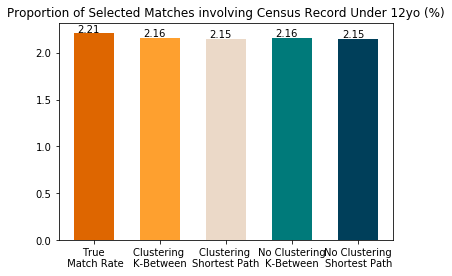

In [111]:
under12 = [base_under12, basic_under12, dijk_under12, no_clus_under12, no_all_under12]

plt.bar(pos, under12, width=3, color=pal)
plt.xticks(pos, labs)
plt.title("Proportion of Selected Matches involving Census Record Under 12yo (%)")
for i in range(0, len(pos)):
    plt.text(x=pos[i] - 1.25, y=under12[i] + 0.01, s = under12[i])
plt.show()

### Confusion Matrix
False positive and negative rate

In [114]:
# heatmap confusion matrix
basic_cm = da.compare_selections(basic.get_result(), df_dist)['confusion_matrix']
dijk_cm = da.compare_selections(dijk.get_result(), df_dist)['confusion_matrix']
no_clus_cm = da.compare_selections(no_clus.get_result(), df_dist)['confusion_matrix']
no_all_cm = da.compare_selections(no_all.get_result(), df_dist)['confusion_matrix']

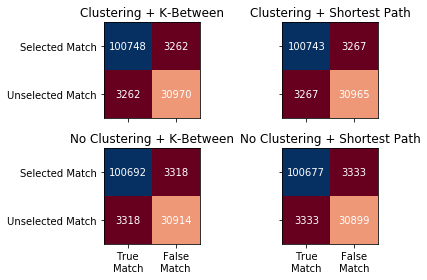

In [133]:
fig, ax = plt.subplots(2, 2)

# clustering + kbetween
ax[0, 0].imshow(np.array(basic_cm), cmap="RdBu")
ax[0, 0].set_title("Clustering + K-Between")

for i in range(2):
    for j in range(2):
        text = ax[0,0].text(j, i, np.array(basic_cm)[i, j],
                            ha="center", va="center", color="w")

# clustering + shortest path
ax[0, 1].imshow(np.array(dijk_cm), cmap="RdBu")
ax[0, 1].set_title("Clustering + Shortest Path")

for i in range(2):
    for j in range(2):
        text = ax[0, 1].text(j, i, np.array(dijk_cm)[i, j],
                             ha="center", va="center", color="w")

# no clustering + k_between
ax[1, 0].imshow(np.array(no_clus_cm), cmap="RdBu")
ax[1, 0].set_title("No Clustering + K-Between")

for i in range(2):
    for j in range(2):
        text = ax[1,0].text(j, i, np.array(no_clus_cm)[i, j],
                            ha="center", va="center", color="w")

# no clustering + shortest path
ax[1,1].imshow(np.array(no_all_cm), cmap="RdBu")
ax[1,1].set_title("No Clustering + Shortest Path")

for i in range(2):
    for j in range(2):
        text = ax[1,1].text(j, i, np.array(no_all_cm)[i, j],
                           ha="center", va="center", color="w")

for axs in ax.flat:
    axs.set_xticks(np.arange(2))
    axs.set_yticks(np.arange(2))
    axs.set_xticklabels(['True\nMatch', 'False\nMatch'])
    axs.set_yticklabels(['Selected Match', 'Unselected Match'])
    axs.label_outer()

fig.tight_layout()
plt.show()

# Error EDA

## Why are some erroneously selected?

In [134]:
basic_errors = da.compare_selections(basic.get_result(), df_dist)['merged_df']

In [4]:
basic_errors.columns

Index(['Unnamed: 0', 'CD_ID', 'CD_FIRST_NAME', 'CD_LAST_NAME', 'MATCH_ADDR',
       'CD_OCCUPATION', 'num_matches', 'CENSUS_ID', 'CENSUS_NAMEFRSCLEAN',
       'CENSUS_NAMELASTB', 'CENSUS_MATCH_ADDR', 'CENSUS_AGE',
       'CENSUS_OCCLABELB', 'WARD_NUM', 'CENSUS_ENUMDIST', 'CENSUS_SEGMENT_ID',
       'CD_BLOCK_NUM', 'census_occupation_listed', 'jaro_winkler_aggr_score',
       'confidence_score', 'LONG', 'LAT', 'age_score', 'census_count',
       'anchor', 'group_ID', 'node_ID', 'letter', 'in_cluster', 'key',
       'spatial_weight', 'selected_algo', 'graph_ID', 'CENSUS_X', 'CENSUS_Y',
       'cd_add_cln', 'cen_add_cln', 'dist', 'type', 'selected_dist'],
      dtype='object')

In [6]:
basic_errors = basic_errors.drop(columns=['Unnamed: 0', 'num_matches', 'WARD_NUM', 'CENSUS_SEGMENT_ID', 'CD_BLOCK_NUM', 'jaro_winkler_aggr_score', 'age_score', 'census_count', 'anchor', 'letter', 'key', 'cd_add_cln', 'cen_add_cln', 'type', 'graph_ID', 'CENSUS_X', 'CENSUS_Y', 'LONG', 'LAT', 'node_ID'])

In [7]:
basic_errors_algo_sel = basic_errors.loc[basic_errors.selected_algo > basic_errors.selected_dist, :]
basic_errors_dist_sel = basic_errors.loc[basic_errors.selected_algo < basic_errors.selected_dist, :]

In [55]:
error_eda = basic_errors_algo_sel.merge(basic_errors_dist_sel, how='inner', on='CD_ID', validate='one_to_one')

In [57]:
# x is selected by algorithm, y selected by distance
confidence_error = error_eda.loc[(error_eda.confidence_score_x != error_eda.confidence_score_y), :]
spatial_weight_error = error_eda.loc[(error_eda.spatial_weight_x != error_eda.spatial_weight_y) & (error_eda.confidence_score_x != error_eda.confidence_score_y), :]
no_error = error_eda.loc[error_eda.spatial_weight_x == error_eda.spatial_weight_y, :]

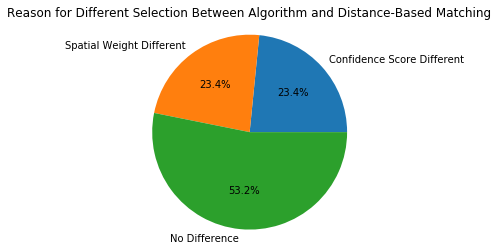

In [65]:
error_labels = ['Confidence Score Different', 'Spatial Weight Different', 'No Difference']
errors = [len(confidence_error), len(spatial_weight_error), len(no_error)]

fig1, ax1 = plt.subplots()
ax1.pie(errors, labels=error_labels, autopct='%1.1f%%')
ax1.axis('equal')
plt.title("Reason for Different Selection Between Algorithm and Distance-Based Matching")
plt.show()

In [67]:
confidence_error[['MATCH_ADDR_x', 'CENSUS_MATCH_ADDR_x', 'confidence_score_x', 'spatial_weight_x', 'CENSUS_ENUMDIST_x', 'CENSUS_MATCH_ADDR_y', 'confidence_score_y', 'spatial_weight_y', 'CENSUS_ENUMDIST_y']].head(20)

MATCH_ADDR_x                   CENSUS_MATCH_ADDR_x  \
4     3 WASHINGTON ST, New York, NY     4 GREENWICH ST, NYC-Manhattan, NY   
11    38 GREENWICH ST, New York, NY    38 GREENWICH ST, NYC-Manhattan, NY   
12    38 GREENWICH ST, New York, NY    38 GREENWICH ST, NYC-Manhattan, NY   
13    38 GREENWICH ST, New York, NY    38 GREENWICH ST, NYC-Manhattan, NY   
18   95 WASHINGTON ST, New York, NY   95 WASHINGTON ST, NYC-Manhattan, NY   
20   89 WASHINGTON ST, New York, NY   71 WASHINGTON ST, NYC-Manhattan, NY   
23   87 WASHINGTON ST, New York, NY   87 WASHINGTON ST, NYC-Manhattan, NY   
25   59 WASHINGTON ST, New York, NY   59 WASHINGTON ST, NYC-Manhattan, NY   
31  122 WASHINGTON ST, New York, NY       24 ALBANY ST, NYC-Manhattan, NY   
32  107 WASHINGTON ST, New York, NY  122 WASHINGTON ST, NYC-Manhattan, NY   
37      1 CARLISLE ST, New York, NY        5 ALBANY ST, NYC-Manhattan, NY   
40       17 ALBANY ST, New York, NY       19 ALBANY ST, NYC-Manhattan, NY   
41       137 CEDAR ST, New York, NY       137 CEDAR ST, NYC-Manhattan, NY   
43  139 WASHINGTON ST, New York, NY  139 WASHINGTON ST, NYC-Manhattan, NY   
50    93 GREENWICH ST, New York, NY    95 GREENWICH ST, NYC-Manhattan, NY   
51    95 GREENWICH ST, New York, NY    95 GREENWICH ST, NYC-Manhattan, NY   
57      25 WILLIAM ST, New York, NY        9 BEAVER ST, NYC-Manhattan, NY   
58        11 BROAD ST, New York, NY      25 WILLIAM ST, NYC-Manhattan, NY   
62       177 BROADWAY, New York, NY       189 BROADWAY, NYC-Manhattan, NY   
69        103 PARK PL, New York, NY       53 WARREN ST, NYC-Manhattan, NY   

    confidence_score_x  spatial_weight_x  CENSUS_ENUMDIST_x  \
4              0.87000           1.87000                  3   
11             0.74000           1.74000                  3   
12             0.70000           1.70000                  3   
13             0.86000           1.86000                  3   
18             0.90000           1.90000                  5   
20             0.65000           1.65000                  5   
23             0.87000           1.87000                  5   
25             0.87000           1.87000                  5   
31             0.87000           1.87000                  6   
32             0.80000           1.80000                  6   
37             0.87000           1.87000                  6   
40             0.63000           1.63000                  7   
41             0.73000           1.73000                  7   
43             0.80000           1.80000                  7   
50             0.80000           1.80000                  8   
51             0.70000           0.70000                  8   
57             0.59000           1.59000                  9   
58             0.68000           1.01000                  9   
62             0.90000           1.90000                 12   
69             0.60000           0.88000                 14   

                     CENSUS_MATCH_ADDR_y  confidence_score_y  \
4     3 WASHINGTON ST, NYC-Manhattan, NY             0.86000   
11    38 GREENWICH ST, NYC-Manhattan, NY             0.70000   
12    38 GREENWICH ST, NYC-Manhattan, NY             0.74000   
13    20 GREENWICH ST, NYC-Manhattan, NY             0.84000   
18   79 WASHINGTON ST, NYC-Manhattan, NY             0.85000   
20   79 WASHINGTON ST, NYC-Manhattan, NY             0.74000   
23   71 WASHINGTON ST, NYC-Manhattan, NY             0.84000   
25   43 WASHINGTON ST, NYC-Manhattan, NY             0.80000   
31  122 WASHINGTON ST, NYC-Manhattan, NY             0.85000   
32  107 WASHINGTON ST, NYC-Manhattan, NY             0.77000   
37      1 CARLISLE ST, NYC-Manhattan, NY             0.85000   
40       137 CEDAR ST, NYC-Manhattan, NY             0.69000   
41       19 ALBANY ST, NYC-Manhattan, NY             0.64000   
43  135 WASHINGTON ST, NYC-Manhattan, NY             0.77000   
50    95 GREENWICH ST, NYC-Manhattan, NY             0.75000   
51    95 GREENWICH ST, NYC-Manhattan, NY             0.75

In [169]:
# for visualization in app
basic_errors.to_csv("../disambiguation_1880/matching_viz/data/matched_viz_v2.csv", index=False)

## Additional Tests

#1 Removing spatial weight for CD matches where there was no choice 

In [10]:
basic_df = pd.read_csv("../data/disambiguated_cluster_kbtw.csv")

In [12]:
basic_modified = basic_df
basic_modified['spatial_weight'] = np.where(basic_modified['census_count'] == 1, basic_modified['spatial_weight'] - 1, basic_modified['spatial_weight'])

In [14]:
basic_modified = basic_modified.drop(columns = ['selected', 'graph_ID'])

In [15]:
import disambiguation.linkage as dl

In [16]:
mod_results = dl.get_matches(basic_modified)

In [17]:
mod_df = mod_results['results']

In [25]:
mod_cm = da.compare_selections(mod_df, df_dist)['confusion_matrix']

In [27]:
# this performed worse than the original
mod_cm

[[100703, 3307], [3307, 30925]]

#2: Fill down approach
- Fill down latlng from anchor point

In [34]:
fill_down = basic_df.drop(columns = ['selected', 'graph_ID', 'CENSUS_X', 'CENSUS_Y', 'dist', 'dist_weight'])
fill_down['CENSUS_X'] = np.where(fill_down['anchor'] == 1, fill_down['LONG'], None)
fill_down['CENSUS_Y'] = np.where(fill_down['anchor'] == 1, fill_down['LAT'], None)
fill_down['CENSUS_X'] = fill_down['CENSUS_X'].fillna(method='ffill').fillna(method='backfill')
fill_down['CENSUS_Y'] = fill_down['CENSUS_Y'].fillna(method='ffill').fillna(method='backfill')

In [36]:
fill_down_df = da.get_dist_based_match(fill_down)['results']

In [38]:
fill_down_cm = da.compare_selections(fill_down_df, df_dist)['confusion_matrix']

In [39]:
# this does better!!!!
fill_down_cm

[[101395, 2615], [2615, 31617]]